<a href="https://colab.research.google.com/github/nxxk23/AI-Engineer/blob/main/ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [472]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [473]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/AIEngineer/ticket.csv")
df.head(5)

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
0,220711333,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Medium,Low,P4,Request,Inext Broadband,[Inext Broadband][Maintenance],R[Inext Broadband][Maintenance][Carrier],Interlink,NaN,2022-07-11 21:50:27.039832+00
1,22072423,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Medium,Low,P4,Request,NOC,[Nutanix-Cloud][VMaaS],R[Nutanix-Cloud][VMaaS][Customer],Other,NaN,2022-07-24 05:00:51.878427+00
2,22081755,BAAC : รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสาร...,รับสายลูกค้าคุณสุริยา เบอร์ 0818863505 แจ้งมีต...,Medium,Low,P4,Request,Inext Broadband,[Inext Broadband][Internet-Standard (Node)],R[Inext Broadband][Internet-Standard (Node)][C...,Other,NaN,2022-08-17 03:50:55.028628+00
3,22091574,Transform You : แจ้งขอข้อมูล Lun ดังนี้ Offsit...,"From: ""Teerayut Saowamok"" <teerayut.sa@transfo...",Low,Medium,P4,Request,NOC,[Flexpod-Cloud][VMaaS],R[Flexpod-Cloud][VMaaS][Customer],Other,NaN,2022-09-15 03:57:30.501931+00
4,22090556,GSB[SD] : แบบคำขอเปลี่ยนแปลงทรัพยากรบน GSB Clo...,From: Servicedesk <servicedesk@inetms.co.th>\n...,Low,Medium,P4,Request,MS-Cloud,[MS-Cloud][VMaaS],I[MS-Cloud][VMaaS][Customer],NaN,NaN,2022-09-05 03:26:02.189656+00


In [474]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222489 entries, 0 to 222488
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   ticket_no             222489 non-null  int64 
 1   subject               222489 non-null  object
 2   description           222409 non-null  object
 3   impact                222489 non-null  object
 4   urgency               222489 non-null  object
 5   priority              222489 non-null  object
 6   ticket_type           222489 non-null  object
 7   group                 222192 non-null  object
 8   service               210042 non-null  object
 9   channel_notification  210000 non-null  object
 10  category              165575 non-null  object
 11  sub_category          16073 non-null   object
 12  created_at            222489 non-null  object
dtypes: int64(1), object(12)
memory usage: 22.1+ MB


In [475]:
data = df.copy()

In [476]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### **numerical columns**

`numerical_columns=['impact', 'urgency', 'priority', 'ticket_type']`

```
use mapping value
```



In [477]:
df['ticket_type'].value_counts()

ticket_type
Request     129146
Incident     91798
Problem       1545
Name: count, dtype: int64

In [478]:
im_ur_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['impact'] = df['impact'].map(im_ur_mapping)
df['urgency'] = df['urgency'].map(im_ur_mapping)

In [479]:
prior_mapping = {'P1': 1, 'P2': 2, 'P3': 3, 'P4': 4, 'P5':5}
df['priority'] = df['priority'].map(prior_mapping)

In [480]:
label_mapping = {'Request': 0, 'Incident': 1, 'Problem': 2}
df['ticket_type'] = df['ticket_type'].map(label_mapping)

In [481]:
check = df[['impact', 'urgency', 'priority', 'ticket_type']]
check.head(5)

,impact,urgency,priority,ticket_type
0,1,0,4,0
1,1,0,4,0
2,1,0,4,0
3,0,1,4,0
4,0,1,4,0


In [482]:
# Calculate the correlation matrix
correlation_matrix = check.corr()

# Extract the correlation of 'ticket_type' with other columns
ticket_type_correlation = correlation_matrix['ticket_type']

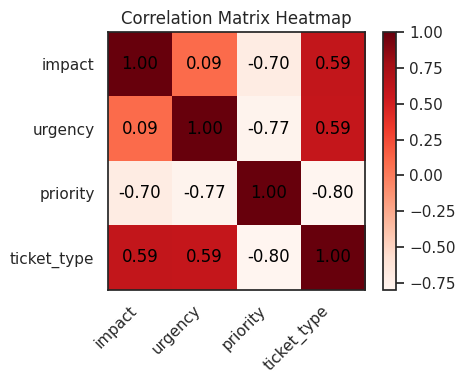

In [483]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 4))
heatmap = plt.imshow(correlation_matrix, cmap='Reds', interpolation='nearest')
plt.colorbar(heatmap)

# Add the column and row names
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)

# Add annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(i, j, f'{correlation_matrix.iloc[j, i]:.2f}',
                 ha='center', va='center', color='black')

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()

# Show the plot
plt.show()

### **features importance**

In [484]:
# Function to convert to categorical codes while handling NaNs
def convert_to_codes_with_nan_handling(column):
    # Convert to category
    column_cat = column.astype('category')
    # Extract codes and handle NaNs
    codes = column_cat.cat.codes
    # Reassign NaNs in the original column
    codes[column.isna()] = np.nan
    return codes

# Apply the function to relevant columns
df['group'] = convert_to_codes_with_nan_handling(df['group'])
df['service'] = convert_to_codes_with_nan_handling(df['service'])
df['channel_notification'] = convert_to_codes_with_nan_handling(df['channel_notification'])
df['category'] = convert_to_codes_with_nan_handling(df['category'])

In [542]:
set(data['group'])

{'BCP',
 'Back Office',
 'Barrel of Excellence (B.O.E.)',
 'CO-CSIRT',
 'CSIRT',
 'Chat Bot',
 'Chat Me',
 'Cloud Infra Migration',
 'D Solution Dot Com',
 'D-Solution Dot Com',
 'Dell-Cloud',
 'Digital Health Informatics (DHI)',
 'Digital Workflow',
 'EDC Pool',
 'Education Platform (EDU)',
 'Flexpod-Cloud',
 'HP-Cloud',
 'Healthcare',
 'INET-IDC1',
 'INET-IDC2',
 'INET-IDC3',
 'INET-MS',
 'INET-VDI',
 'Inext Broadband',
 'Infra-Cloud',
 'Infra-Network',
 'Infra-Virtual Firewall',
 'Internal Service',
 'Internet of Thing (IoT)',
 'Local Life Platform',
 'Local Life-Ecommerce',
 'Local Life-Food',
 'MNSP',
 'MOPH - หมอพร้อม (ใหญ่)',
 'MS-Cloud',
 'Manage AI',
 'Mandala KhonKaen',
 'Mobilyst',
 'My Platform',
 'NOC',
 'NOCKKC',
 'Network',
 'Network-Security',
 'Nex Gen Shop (NGS)',
 'Nutanix-Cloud',
 'OLS-Container',
 'One Authen',
 'One Centric',
 'One Conference',
 'One Electronic Billing',
 'One ID',
 'One Portal',
 'One Space',
 'One-Email',
 'One-Email [Exchange Mail]',
 'Openland

In [543]:
df[df['group'].isnull()]['channel_notification'].value_counts()

channel_notification
336.0    30
563.0    22
564.0    16
337.0    12
339.0     9
364.0     8
351.0     2
47.0      1
548.0     1
Name: count, dtype: int64

In [548]:
df[df['channel_notification'] == 336]['ticket_type']

ticket_type
1    70
Name: count, dtype: int64

In [544]:
df[(df['channel_notification'] == 336) & (df['group'].isnull())] # ==> fill group with 39

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
8499,220825355,JV-One Box : NOC ได้รับ Alert VM : Application...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-08-25 17:02:05.015914+00
12157,22072890,JV-One Box : NOC ได้รับ Alert [CN0-000353][JV-...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,2,1,2,1,NaN,NaN,336.0,NaN,NaN,2022-07-28 20:37:40.811843+00
24238,220929279,One-Box : NOC ได้รับ Alert [JV-One Box] Serv...,\n\nFrom: onebox@inet.co.th\nTo: onebox@inet.c...,1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-09-29 17:14:32.599223+00
32541,220506209,One Centric (E-Tax Project :Onebox) : NOC ได้ร...,"From: ""INET_Flexpod Cloud Monitor"" <INET_Flexp...",1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-05-06 09:09:50.048674+00
35570,220429210,JV-One Box : NOC ได้รับ Alert VM Name : Applic...,\n\nFrom: onebox@inet.co.th\nTo: onebox@inet.c...,2,2,1,1,NaN,NaN,336.0,NaN,NaN,2022-04-29 09:09:29.012849+00
35641,220427268,JV-One Box : NOC ได้รับ Alert VM : pplication ...,\n\nFrom: onebox@inet.co.th\nTo: onebox@inet.c...,2,2,1,1,NaN,NaN,336.0,NaN,NaN,2022-04-27 11:23:22.070395+00
35879,220503139,JV-One Box : NOC ได้รับ Alert VM Name : Applic...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-05-03 06:41:51.644761+00
35950,220530642,JV-One Box : noc ได้รับ Alert [JV-One Box] Ser...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,2,1,2,1,NaN,NaN,336.0,NaN,NaN,2022-05-30 18:08:29.722404+00
35969,22042842,JV-One Box : NOC ได้รับ Alert VM Name : Applic...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,2,2,1,1,NaN,NaN,336.0,NaN,NaN,2022-04-28 02:56:01.83574+00
35973,22042843,JV-One Box : NOC ได้รับ Alert VM Name : Applic...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-04-28 02:57:21.604094+00


In [550]:
prob = df[]

array(['From: "NQM Interlink Telecom" <nqm@interlinktelecom.co.th>\nTo: "INET Network Operation" <noc@inet.co.th>, "op-bb" <op-bb@inet.co.th>, inext-service@inet.co.th\nCc: planwork@interlinktelecom.co.th, "k chariya" <k.chariya@interlinktelecom.co.th>\nSent: Monday, July 11, 2022 4:06:20 PM\nSubject: !!! Urgent !!! : ขอจัดส่งจดหมายแจ้งกำหนดการปรับปรุงบริการวงจร  จำนวน 10 วงจร รายละเอียดตามจดหมายแจ้งเลขที่ NQM/2022-849-023\n\n \n\n \n\n \n\n \n\nเรื่อง        ขอแจ้งกำหนดการปรับปรุงการให้บริการ \n\n \n\nเรียน       บริษัท ไอเน็กซ์ บรอดแบนด์ จำกัด\n\n\nขอจัดส่งจดหมายแจ้งปรับปรุงการบริการวงจร      จำนวน 10 วงจร\n\nวัตถุประสงค์การดำเนินการ              :   ปรับปรุงบริการโครงข่าย เนื่องจากจะดำเนินการ Replace อุปกรณ์ภายใน Node\n\nพื้นที่ดำเนินการ                                 :    Node บุรีรัมย์ Site Interlink\n\nวัน เริ่มดำเนินการ                              :   วันที่ 15 กรกฎาคม 2565  เวลา 00.00 น. (คืนวันพฤหัสบดีที่ 14 กรกฎาคม 2565)\n\nวัน สิ้นสุดดำเนินการ                         :   ว

In [485]:
df.isnull().sum()

ticket_no                    0
subject                      0
description                 80
impact                       0
urgency                      0
priority                     0
ticket_type                  0
group                      297
service                  12447
channel_notification     12489
category                 56914
sub_category            206416
created_at                   0
dtype: int64

In [486]:
df[df['group'].isnull()]['subject'].value_counts()

subject
ลงทะเบียน Computer                                                                                                                                              5
แจ้งเคส 10741 โรงพยาบาลวชิระภูเก็ต                                                                                                                              2
แจ้งเคส 11874 โรงพยาบาลสิริเวช จันทบุรี                                                                                                                         2
[JV-Platform][One Box] : ขอข้อมูลใบเสร็จ เดอะมอลล์กรุ๊ป                                                                                                         1
[JV] ManageAI : Noc ได้รับ Alert VM : [ManageAI-Checkup-Node-06-POC] [IP:(10.100.101.26)] มีการใช้งาน Memory = 90% เมื่อ Saturday, June 11, 2022 10:40:49 AM    1
                                                                                                                                                               ..
[JV-Platform][One Bo

## **group missing handling**

In [504]:
df[df['group'].isnull()]['channel_notification'].value_counts()

channel_notification
336.0    30
563.0    22
564.0    16
337.0    12
339.0     9
364.0     8
351.0     2
47.0      1
548.0     1
Name: count, dtype: int64

In [538]:
df[df['channel_notification'] == 548]['group'].value_counts()

group
50.0    1432
40.0      28
39.0       1
53.0       1
Name: count, dtype: int64

In [532]:
#df[(df['channel_notification'] == 351) & (df['group']==39)]

In [451]:
data.loc[120100]['group'] # ==> 40

'NOCKKC'

In [452]:
data.loc[135295]['group'] #==> 39

'NOC'

In [447]:
## ต้องการทราบชื่อบริษัท ระหว่าง NOC กับ NOCKKC ==> แต่ถึงเอาชื่อมาก็ต้องมานั่ง find

In [426]:
df[(df['channel_notification'] == 563) & (df['group'].isnull())]

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
367,22081765,[JV-Platform][One Box] : ขอข้อมูลใบเสร็จ เดอะม...,"From: ""supaporn sungsingh"" <Supaporn.Sungsingh...",1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-08-17 04:04:51.826911+00
2862,220715188,[JV-Platform][One Box] : ลูกค้าสอบถามเรื่องการ...,"จาก: ""info@ribboncenter.com"" <ribboncenter.ltd...",1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-07-15 09:02:09.211736+00
3175,220901254,[JV-Platform][One Box] : ลูกค้าสอบถามเอกสาร Et...,ลูกค้าสอบถามเอกสาร Etax บริษัทลูกค้าส่งมาให้หร...,1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-09-01 10:01:19.084357+00
3233,22081781,[JV-Platform][One Box] : คุณรุ่งนภาบริษัท นีโ...,คุณรุ่งนภา\nบริษัท นีโอ คอปเปอร์เรท\nเบอร์ติด...,1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-08-17 04:19:30.894597+00
5003,220721105,[JV-Platform][One Box] : คุณจุฑาทิพย์ 08980286...,รับสาย คุณจุฑาทิพย์ 0898028676\nบริษัท นิวซิตี...,1,0,4,0,NaN,NaN,563.0,176.0,NaN,2022-07-21 04:31:05.620523+00
5186,220726117,[JV-Platform][One Box] : บริษัท ทรูลี่ ออร์แกน...,"From: ""Anatcha Limpee"" <anatcha@truly-organics...",1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-07-26 04:26:23.044799+00
6116,22071833,ONE-BOX-แจ้งตรวจสอบเพิ่มเติม download csv ยอด...,"From: ""Boonvanit Tonsang"" <toboonvanit@central...",1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-07-18 02:39:57.926105+00
9012,220727141,[JV-Platform][One Box] : บริษัท เบต้าว้าวจำกัด...,บริษัท เบต้าว้าวจำกัด \nเบอร์ติดต่อ : 06140828...,1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-07-27 06:40:02.606775+00
10303,220804167,[JV-Platform][One Box] : คุณขวัญ บริษัท บุญตง...,คุณขวัญ \nบริษัท บุญตงกี่ ประเทศไทย\nเบอร์ติดต...,1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-08-04 08:13:41.589081+00
12075,22080516,[JV-Platform][One Box] : คุณกรภัทร บริษัท ไตต...,คุณกรภัทร \n023902085\nบริษัท ไตตันโค อินเตอร์...,1,0,4,0,NaN,NaN,563.0,NaN,NaN,2022-08-05 02:25:31.666492+00


### **correlation**

<Axes: >

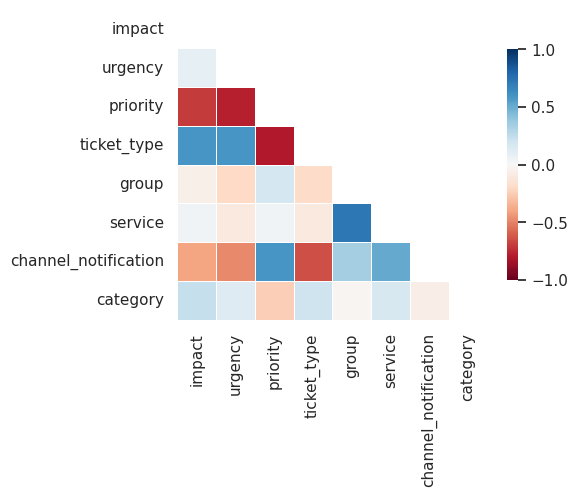

In [365]:
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 6))
cmap = sns.color_palette("RdBu", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [366]:
corr['ticket_type'].sort_values(ascending=False)

ticket_type             1.000000
impact                  0.593521
urgency                 0.587577
category                0.207974
service                -0.096409
group                  -0.191779
channel_notification   -0.643220
priority               -0.797715
Name: ticket_type, dtype: float64

## **text analytic**

#### **ลงทะเบียน Computer**

In [367]:
data[data['subject']=='ลงทะเบียน Computer']['group'].value_counts() #1255 ==> ต้องเติม null 5 rows ด้วย Internal Service

group
Internal Service    1250
Name: count, dtype: int64

In [368]:
data[data['subject']=='ลงทะเบียน Computer']['ticket_type'].value_counts()

ticket_type
Request    1253
Problem       2
Name: count, dtype: int64

In [369]:
data[(data['ticket_type']=='Request') & (data['subject']=='ลงทะเบียน Computer')].head(5)

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
74,2305086,ลงทะเบียน Computer,ลงทะเบียนคอมพิวเตอร์พนักงานเข้าใหม่,Low,Low,P5,Request,Internal Service,NaN,Internal Service,NaN,NaN,2023-05-08 03:57:09.035868+00
459,2310031,ลงทะเบียน Computer,ลงทะเบียนเปลี่ยนคอมพิวเตอร์ใหม่,Low,Low,P5,Request,Internal Service,Internal Service,Internal Service,NaN,NaN,2023-10-03 02:31:19.649149+00
6269,2311237,ลงทะเบียน Computer,ลงทะเบียนคอมพิวเตอร์พนักงานใหม่วันที่ 16/11/2566,Low,Low,P5,Request,Internal Service,Internal Service,Internal Service,NaN,NaN,2023-11-23 04:00:13.850419+00
9877,2311235,ลงทะเบียน Computer,ลงทะเบียบคอมพิวเตอร์พนักงานใหม่ \nวันที่ 16/11...,Low,Low,P5,Request,Internal Service,Internal Service,Internal Service,NaN,NaN,2023-11-23 03:49:50.066949+00
13663,23080310,ลงทะเบียน Computer,ตรวจสอบคอมพิวเตอร์เนื่งจากเป็นพนักงานใหม่,Low,Low,P5,Request,Internal Service,Internal Service,Internal Service,NaN,NaN,2023-08-03 07:19:03.477451+00


In [310]:
df[(df['ticket_type']==2) & (df['subject']=='ลงทะเบียน Computer')] # ต้องเปลี่ยน type ไปที่ 0 ไม่ก็ ลบ 2 rows นี้ออก

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
103786,2308222,ลงทะเบียน Computer,เปลี่ยนเครื่อง,0,0,5,2,Internal Service,Internal Service,One Chat,NaN,NaN,2023-08-22 04:12:39.211728+00
116715,2309016,ลงทะเบียน Computer,พนักงานใหม่ขอใช้ WIFI 0902576766,0,0,5,2,Internal Service,Internal Service,Internal Service,NaN,NaN,2023-09-01 06:53:38.44367+00


In [551]:
df[(df['channel_notification'] == 364) & (df['group'].isnull())] # ==> fill group with 27 แต่ index 76457 ตร่กโพด

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
76457,2303304,test open ticket internal nu'man2,test,2,2,1,1,NaN,NaN,364.0,NaN,NaN,2023-03-30 17:15:36.290598+00
86003,23050210,ลงทะเบียน Computer,ตรวจคอมพิวเตอร์พนักงานเข้าใหม่,0,0,5,0,NaN,NaN,364.0,NaN,NaN,2023-05-02 09:03:43.960954+00
86405,2304202,ติดตั้ง Software,ติดตั้งMicrosoft office,0,0,5,0,NaN,NaN,364.0,NaN,NaN,2023-04-20 04:23:41.547222+00
92725,2305031,ลงทะเบียน Computer,ลงทะเบียนคอมพนักงานเข้าใหม่,0,0,5,0,NaN,NaN,364.0,NaN,NaN,2023-05-03 02:31:43.223309+00
93587,2305033,ลงทะเบียน Computer,ลงทะเบียนคอมพนักงานเข้าใหม่,0,0,5,0,NaN,NaN,364.0,NaN,NaN,2023-05-03 03:02:33.123812+00
94856,2305034,ลงทะเบียน Computer,พนักงานลงทะเบียนคอมพิวเตอร์,0,0,5,0,NaN,NaN,364.0,NaN,NaN,2023-05-03 03:49:03.739757+00
95133,2305026,ปัญหาอื่นๆ,โปรเเกรมมีปัญหา เนื่องจากเป็นโปรเเกรมตัวทดลอง ...,1,0,4,2,NaN,NaN,364.0,NaN,NaN,2023-05-02 08:12:00.257661+00
95502,2305029,ลงทะเบียน Computer,ลงทะเบียนคอมพนักงานเข้าใหม่,0,0,5,0,NaN,NaN,364.0,NaN,NaN,2023-05-02 08:38:01.970014+00


#### **Group**

In [322]:
df.isnull().sum()

ticket_no                    0
subject                      0
description                 80
impact                       0
urgency                      0
priority                     0
ticket_type                  0
group                      297
service                  12447
channel_notification     12489
category                 56914
sub_category            206416
created_at                   0
dtype: int64

In [316]:
grouped = df.groupby('group')[['ticket_type', 'subject', 'priority', 'service', 'channel_notification', 'category']]
grouped

In [317]:
df['group'].value_counts()

group
Network                    27223
NOC                        25466
Flexpod-Cloud              24698
Nutanix-Cloud              24036
Inext Broadband            20617
                           ...  
Seamless                       5
Infra-Virtual Firewall         3
Servicedesk                    3
Internet of Thing (IoT)        1
INET-VDI                       1
Name: count, Length: 71, dtype: int64

In [286]:
# Group by 'group' and count rows, unique channel_notification, and unique service
group_summary = df.groupby('group').agg({
    'ticket_no': 'size',  # Count rows in each group
    'channel_notification': 'nunique',  # Count unique values of channel_notification in each group
    'service': 'nunique'  # Count unique values of service in each group
}).reset_index()

# Sort groups by count of rows in descending order
group_summary_sorted = group_summary.sort_values(by='ticket_no', ascending=False)

# Display the top N groups (e.g., top 20)
top_groups = group_summary_sorted
top_groups

,group,ticket_no,channel_notification,service
41,Network,27223,146,45
39,NOC,25466,240,152
15,Flexpod-Cloud,24698,69,32
44,Nutanix-Cloud,24036,63,40
23,Inext Broadband,20617,39,24
...,...,...,...,...
60,Seamless,5,1,1
61,Servicedesk,3,3,3
26,Infra-Virtual Firewall,3,3,3
28,Internet of Thing (IoT),1,1,1


In [235]:
a = df[(df['category'] == 'Ping Down') | (df['category'] == 'Down')]
a['group'].value_counts()

group
Inext Broadband     13585
Network              5185
Nutanix-Cloud        2717
Flexpod-Cloud        2096
NOC                   863
Dell-Cloud            507
HP-Cloud              355
MS-Cloud              246
Openlandscape         213
Network-Security      206
INET-MS                62
Healthcare             57
EDC Pool               27
INET-IDC3              22
INET-IDC2              11
INET-IDC1               7
Unix-Cloud              5
My Platform             3
MNSP                    2
One-Email               1
Opensource-Cloud        1
Name: count, dtype: int64

In [218]:
df[df['group']=='Thai Withholding Tax Service']['ticket_type'].value_counts()

ticket_type
1    27
Name: count, dtype: int64

In [191]:
df[df['subject']=='ปัญหาอื่นๆ']['ticket_type'].value_counts() # 0 ==> ตรวจคอม , 1 ==> คอมใช้ wifi ไม่ได้ , 2 ตรวจคอม

ticket_type
2    1243
0       1
1       1
Name: count, dtype: int64

In [198]:
df['subject'].value_counts()

subject
ลงทะเบียน Computer                                                                                                                                                                     1255
ปัญหาอื่นๆ                                                                                                                                                                             1245
ตรวจคอมพิวเตอร์พนักงานลาออก                                                                                                                                                             358
Printer                                                                                                                                                                                 331
ลงทะเบียนคอมพิวเตอร์                                                                                                                                                                    200
                                                    

In [187]:
df['group'].value_counts()

group
Network                    27223
NOC                        25466
Flexpod-Cloud              24698
Nutanix-Cloud              24036
Inext Broadband            20617
                           ...  
Seamless                       5
Infra-Virtual Firewall         3
Servicedesk                    3
Internet of Thing (IoT)        1
INET-VDI                       1
Name: count, Length: 71, dtype: int64

In [207]:
df[df['group']=='Nutanix-Cloud']['ticket_type'].value_counts() # ส่วนใหญ่ ==> รบกวน + แจ้ง

ticket_type
0    13841
1    10191
2        4
Name: count, dtype: int64

In [208]:
df[df['group']=='Flexpod-Cloud']['ticket_type'].value_counts() # ส่วนใหญ่ ==> แจ้งขอรายงาน

ticket_type
0    13459
1    11235
2        4
Name: count, dtype: int64

In [209]:
df[df['group']=='Network']['ticket_type'].value_counts() # ส่วนใหญ่ ==> อุปกรณ์ที่มี IP Blacklist ภายนอกองค์กรมายังอุปกรณ์ภายในองค์กร

ticket_type
1    13739
0    13473
2       11
Name: count, dtype: int64

In [211]:
df[df['group']=='Inext Broadband']['ticket_type'].value_counts()  # ส่วนใหญ่ ==> วงจร มีสถานะ Down

ticket_type
1    14669
0     5939
2        9
Name: count, dtype: int64

In [182]:
df[df['subject']=='ตรวจคอมพิวเตอร์พนักงานลาออก']['group'].value_counts()

group
Internal Service    358
Name: count, dtype: int64

## **word token**

In [85]:
%pip install nltk pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 20.1 MB/s eta 0:00:00


In [84]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_stopwords

In [88]:
# Tokenization function
def tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return tokens

In [92]:
nltk.download('stopwords')
nltk.download('punkt')

# Define English stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Define Thai stopwords
thai_stopwords = set(['และ', 'ที่', 'ซึ่ง', 'ได้', 'ให้', 'ของ', 'ใน', 'การ', 'ว่า', 'ด้วย', 'หรือ', 'เป็น', 'ไป', 'จาก'])
stop_words = stop_words.union(thai_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [93]:
# Apply the tokenization function and count the words
all_words = []
for subject in df['subject']:
    all_words.extend(tokenize(subject))

word_counts = Counter(all_words)

# Display the most common words
common_words = word_counts.most_common(10)
print(common_words)

[('ip', 74237), ('เมื่อ', 50343), ('noc', 44792), ('closed', 42514), ('vm', 38232), ('alert', 37816), ('มีสถานะ', 31267), ('ได้รับ', 30366), ('close', 30329), ('pm', 24756)]
